In [87]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import scipy
import joblib
import copy
from sklearn.decomposition import PCA
import seaborn

In [88]:
def generate_kmer_database(path_to_fasta_db,path_outfile):
    outfile = open(path_outfile,"w+")
    with open(path_to_fasta_db,"r") as f:
        for line in f:
            if line[0] != ">":
                window = 9
                for i in range(len(line)-window):
                    print(line[i:i+window],file=outfile)
    outfile.close()


def read_results_files(path_to_results,peptide_lengths_of_interest,MHCs_of_interest=None):
    """Reading the results derived from the netMHCIIpan output and returns a directory of 
        the epitopes with the general structure: data[protein][allele] = [epitope,epitope]
    Args:
        path_to_results (str): Path to the netMCHIIpan results

    Returns:
        dict,dict: The results saved in a SB and WB dict
    """
    # The dataframes
    SB_score = dict()
    for file in os.listdir(path_to_results):
        protein = file.split(".")[1]
        length = file.split(".")[2]
        if length not in peptide_lengths_of_interest:
            continue

        SB_score[protein] = dict()

        infile = open(path_to_results + "/" + file, "r")
        for line in infile:
            line = line.split()
            if len(line) > 1:
                if line[1] == "Allele:":
                    allele = line[-1]
                elif line[-1] == "<=SB":
                    if MHCs_of_interest is not None:
                        if allele in MHCs_of_interest:
                            if allele not in SB_score[protein].keys():
                                # [pos,peptide,of,core,identity, binding_score]
                                SB_score[protein][allele] = [[int(line[0]), line[2], int(line[3]), line[4], line[6], line[8]]]
                            else:
                                # [pos,peptide,of,core,identity, binding_score]
                                SB_score[protein][allele].append([int(line[0]), line[2], int(line[3]), line[4], line[6], line[8]])
                    else:
                        if allele not in SB_score[protein].keys():
                                # [pos,peptide,of,core,identity, binding_score]
                                SB_score[protein][allele] = [[int(line[0]), line[2], int(line[3]), line[4], line[6], line[8]]]
                        else:
                            # [pos,peptide,of,core,identity, binding_score]
                            SB_score[protein][allele].append([int(line[0]), line[2], int(line[3]), line[4], line[6], line[8]])

    return SB_score


def get_HLA_freqs(path_to_HLA_frequencies):
    """Getting the frequencies of the HLA molecules in the In vitro dataset

    Args:
        path_to_HLA_frequencies (str): path to the frequencies

    Returns:
        dict: HLA with it's frequency
    """
    HLA_freqs = dict()
    infile = open(path_to_HLA_frequencies, "r")
    for line in infile:
        line = line.split()
        allele = line[0]
        freq = float(line[1])
        HLA_freqs[allele] = freq
    return HLA_freqs


def encode_peptide_aaindex(aa_seq,aaindex_PCA):
    """Enocding an aa-seqquence using the AAindex encoding scheme.

    Args:
        aa_seq (str): The aa-sequence we want to encode
        aaindex_PCA (pd.DataFrame):  A pandas dataframe which holds the AAindex encoding scheme

    Returns:
        np.array: The encoded peptide sequence
    """

    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(PCs)]))
        else:
            try:
                encoded_aa_seq.append(aaindex_PCA.loc[aa].to_numpy())
            except KeyError:
                print("Encoding error")
                sys.exit(1)
    return np.array(encoded_aa_seq)


def add_binding_core_annotataions(peptide,core):
    core_start = peptide.find(core)
    core_indexes = list(range(core_start,core_start + len(core)))
    indexes = np.array([0 if i not in core_indexes else 1 for i in range(len(peptide))])
    indexes = indexes.reshape(-1,1)
    return np.array(indexes)


def predict_immunogenecity(peptide,core,path_to_models):
    aaindex_PCA = pd.read_csv('/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/PCA_repr_aa.csv',index_col=0)
    aaindex_PCA = (aaindex_PCA - aaindex_PCA.mean()) / aaindex_PCA.std()
    aaindex_encoding = encode_peptide_aaindex(peptide,aaindex_PCA)
    core_encoding = add_binding_core_annotataions(peptide,core)
    total_encoding = np.concatenate((core_encoding,aaindex_encoding),axis=1)
    total_encoding = total_encoding.reshape(1,-1)

    all_predictions = []
    for model in os.listdir(path_to_models):
        path_to_model = os.path.join(path_to_models,model)
        regressor = joblib.load(path_to_model)
        prediction = regressor.predict(total_encoding)
        all_predictions.append(prediction)

    average_prediction = np.mean(all_predictions)
    return average_prediction


def read_immunogenecity(path_to_immunogenecity):
    immunogenecity = dict()
    with open(path_to_immunogenecity,"r") as infile:
        for line in infile:
            protein,score = line.split()
            immunogenecity[protein] = float(score)
    return immunogenecity

def get_9_mer_lib(path_to_ninemers):
    """Creates the 9mer libaries used to create the toll profiles. Takes in the results from fasta2pep and creates dictionary with the libary

    Args:
        path_to_ninemers (str): path to results from fasta2pep

    Returns:
        dict: key is 9mer and value is the count of occurences
    """
    infile = open(path_to_ninemers,"r")
    lib = dict()
    total_lines = infile.readlines()
    for line in tqdm(total_lines,total=len(total_lines)):
        line = line.split()
        nine_mer = line[0]
        if nine_mer not in lib.keys():
            lib[nine_mer] = 1
        else:
            lib[nine_mer] += 1
    return lib

# generate_kmer_database("/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/extracted_variable_sequences_sorted_redundancy_reduced_clean_format.fasta","/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/code_github/data/9_mers_IMGT_new_database.txt")
path_to_models = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/models"
path_to_IMGT_9_mers = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/code_github/data/9_mers_IMGT_new_database.txt" # PATH TO IMGT 9-mer database
path_to_humab_9mers = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/Humab_theraputics_data/9_mer_database_humab.txt" # PATH TO HUMAB 9-mer databaser
IMGT_9mers = get_9_mer_lib(path_to_IMGT_9_mers)
Humab_9mers = get_9_mer_lib(path_to_humab_9mers)

100%|██████████| 43313/43313 [00:00<00:00, 3341080.10it/s]


In [89]:
path_to_results = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/Humab_theraputics_data/newMHCIIpan_results"
lengths_of_interest = ["15"]
MHCs_of_interest = ['DRB1_0101', 'DRB3_0202', 'DRB1_0701', 'DRB1_0401', 'DRB1_1101', 'DRB4_0101', 'DRB5_0101', 'DRB1_1501', 'DRB1_0407', 'DRB1_0301', 'DRB1_0403', 'DRB1_1301', 'DQA10301-DQB10302', 'DRB1_0901', 'DRB1_1406', 'DQA10102-DQB10602', 'DRB1_1402', 'DRB1_0802', 'DQA10501-DQB10201', 'DQA10101-DQB10501']
SB_results = read_results_files(path_to_results,lengths_of_interest,MHCs_of_interest=None)
path_freqs = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/code_github/data/DRB_world_average copy.txt"
path_freqs = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/code_github/data/IX_HLA_frequencies.txt"
HLA_freqs = get_HLA_freqs(path_freqs)
path_to_immunogenecity = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/Humab_theraputics_data/Humab_immunogenecity.txt"
imm_scores = read_immunogenecity(path_to_immunogenecity)


In [124]:
testing_data = ["IL21R","Atezolizumab","Natalizumab","Bevacizumab","Nivolumab","Infliximab","Herceptin","Bococizumab"]
SB_results = {protein:SB_results[protein] for protein in SB_results.keys() if protein not in testing_data and imm_scores[protein] <= 40}
imm_scores = {protein:imm_scores[protein] for protein in imm_scores.keys() if protein not in testing_data and imm_scores[protein] <= 40}

## Analyze immunogenecity distrobutions

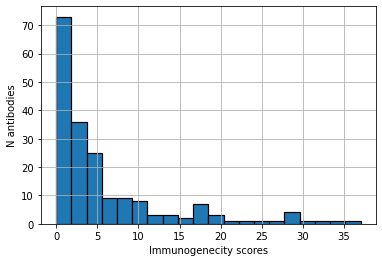

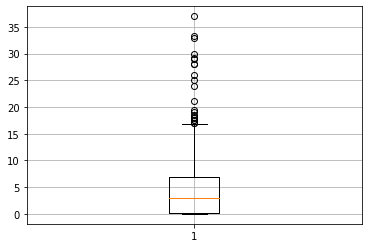

In [125]:
imm = np.array([float(x) for x in imm_scores.values()])
plt.hist(imm,bins=20,edgecolor='black', linewidth=1.2)
plt.xlabel("Immunogenecity scores")
plt.ylabel("N antibodies")
plt.grid(True)
plt.show()
plt.boxplot(imm)
plt.grid(True)
plt.show()

In [126]:
def predict_scores_subtract_self(SB_results,IMGT_9mers):
    predicted_scores = dict()
    predicted_imm_scores = []
    for theraputic in tqdm(SB_results.keys(),total=len(SB_results.keys())):
        predicted_scores[theraputic] = 0
        for allele in SB_results[theraputic].keys():
            try:
                allele_freq = HLA_freqs[allele]
            except KeyError:
                continue
            for peptide in SB_results[theraputic][allele]:
                if peptide[3] not in IMGT_9mers.keys():
                    if allele[0:4] == "DRB1":
                        predicted_scores[theraputic] += allele_freq
                    else:
                        predicted_scores[theraputic] += 0.2*allele_freq
                else:
                    if allele[0:4] == "DRB1":
                        predicted_scores[theraputic] -= allele_freq
                    else:
                        predicted_scores[theraputic] -= 0.2*allele_freq
    return predicted_scores


def predict_scores_two_state(SB_results,IMGT_9mers):
    predicted_scores = dict()
    predicted_imm_scores = []
    for theraputic in tqdm(SB_results.keys(),total=len(SB_results.keys())):
        predicted_scores[theraputic] = 0
        for allele in SB_results[theraputic].keys():
            try:
                allele_freq = HLA_freqs[allele]
            except KeyError:
                continue
            for peptide in SB_results[theraputic][allele]:
                if peptide[3] not in IMGT_9mers.keys():
                    if allele[0:4] == "DRB1":
                        predicted_scores[theraputic] += allele_freq
                    else:
                        predicted_scores[theraputic] += 0.2*allele_freq
    return predicted_scores

def predict_scores_one_state(SB_results,IMGT_9mers):
    predicted_scores = dict()
    predicted_imm_scores = []
    for theraputic in tqdm(SB_results.keys(),total=len(SB_results.keys())):
        predicted_scores[theraputic] = 0
        for allele in SB_results[theraputic].keys():
            try:
                allele_freq = HLA_freqs[allele]
            except KeyError:
                continue
            for peptide in SB_results[theraputic][allele]:
                if allele[0:4] == "DRB1":
                    predicted_scores[theraputic] += allele_freq
                else:
                    predicted_scores[theraputic] += 0.2*allele_freq
    return predicted_scores

In [127]:
three_way_scores = predict_scores_subtract_self(SB_results,IMGT_9mers)
two_state_scores = predict_scores_two_state(SB_results,IMGT_9mers)
one_state_scores = predict_scores_one_state(SB_results,IMGT_9mers)

100%|██████████| 190/190 [00:00<00:00, 42898.09it/s]


In [128]:
theraputics = [x for x in SB_results.keys()]
threeway_scores = [three_way_scores[x] for x in theraputics]
twostate_scores = [two_state_scores[x] for x in theraputics]
onestate_scores = [one_state_scores[x] for x in theraputics]
immunogenecity_scores = [imm_scores[x] for x in theraputics]

In [129]:
predictions_df = pd.DataFrame({"Theraputics":theraputics,"Threeway":threeway_scores,"Twostate":twostate_scores,"Onestate":onestate_scores,"immunogenecity_scores":immunogenecity_scores})
predictions_df = predictions_df[predictions_df.Theraputics != "Hemocyanin"]

## Boot-strapping - Is Three-way significantly better than Two-state

In [130]:
import random
random.seed(0)
N_samples = 10000
threeway_better_than_two_state = 0
for N in range(N_samples):
    bootstrapped_df = predictions_df.sample(n=predictions_df.shape[0], replace=True)
    threeway_pearson_coeff, p_value = scipy.stats.pearsonr(bootstrapped_df["Threeway"],bootstrapped_df["immunogenecity_scores"])
    twostate_pearson_coeff, p_value = scipy.stats.pearsonr(bootstrapped_df["Twostate"],bootstrapped_df["immunogenecity_scores"])
    if threeway_pearson_coeff > twostate_pearson_coeff:
        threeway_better_than_two_state += 1

print(threeway_better_than_two_state)

3311


## One-state model for prediction immunogenecity

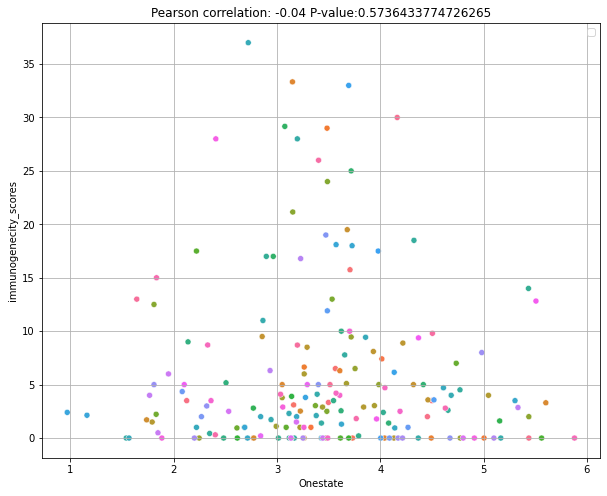

In [131]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=predictions_df,x="Onestate",y="immunogenecity_scores",hue="Theraputics")
# coeff, p_value = scipy.stats.spearmanr(predictions_df["Onestate"],predictions_df["immunogenecity_scores"])
coeff, p_value = scipy.stats.pearsonr(predictions_df["Onestate"],predictions_df["immunogenecity_scores"])
if "e" in str(p_value):
    pre,power = str(p_value).split("e-")
    p_value = f"{pre[:3]}e-{power}"

plt.title("Pearson correlation: " + str(round(coeff,2)) +" P-value:"+ str(p_value))
plt.grid(True)
plt.legend('')
plt.show()

## Two-state models predictions

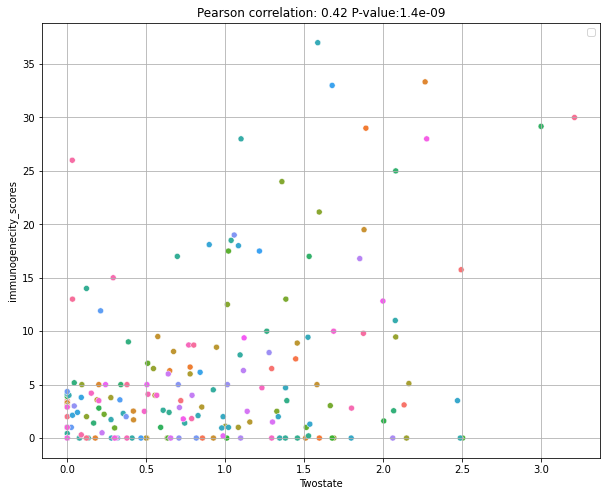

In [132]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=predictions_df,x="Twostate",y="immunogenecity_scores",hue="Theraputics")
# coeff, p_value = scipy.stats.spearmanr(predictions_df["Twostate"],predictions_df["immunogenecity_scores"])
coeff, p_value = scipy.stats.pearsonr(predictions_df["Twostate"],predictions_df["immunogenecity_scores"])
if "e" in str(p_value):
    pre,power = str(p_value).split("e-")
    p_value = f"{pre[:3]}e-{power}"

plt.title("Pearson correlation: " + str(round(coeff,2)) +" P-value:"+ str(p_value))
plt.grid(True)
plt.legend('')
plt.show()

## Prediction with the three-state model with optimal threshold

**Fitting polynomial to data**

In [133]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=2
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(predictions_df["Threeway"].to_numpy().reshape(-1,1),predictions_df["immunogenecity_scores"].to_numpy().reshape(-1,1))

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

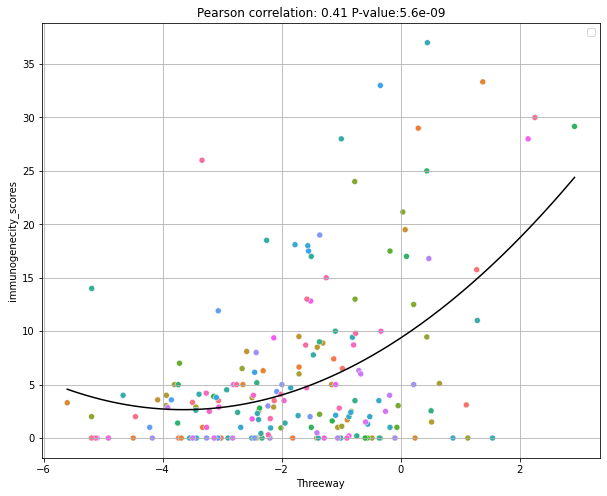

In [134]:
fig = plt.figure(figsize=(10,8))
X_seq = np.linspace(predictions_df["Threeway"].to_numpy().reshape(-1,1).min(),predictions_df["Threeway"].to_numpy().reshape(-1,1).max(),300).reshape(-1,1)
plt.plot(X_seq,polyreg.predict(X_seq),color="black")
sns.scatterplot(data=predictions_df,x="Threeway",y="immunogenecity_scores",hue="Theraputics")
# coeff, p_value = scipy.stats.spearmanr(predictions_df["Threeway"],predictions_df["immunogenecity_scores"])
coeff, p_value = scipy.stats.pearsonr(predictions_df["Threeway"],predictions_df["immunogenecity_scores"])
if "e" in str(p_value):
    pre,power = str(p_value).split("e-")
    p_value = f"{pre[:3]}e-{power}"

plt.title("Pearson correlation: " + str(round(coeff,2)) +" P-value:"+ str(p_value))
plt.grid(True)
plt.legend('')
plt.show()

In [135]:
from sklearn.metrics import r2_score
predictions = X_seq,polyreg.predict(X_seq)

coefficient_of_dermination = r2_score(predictions_df["immunogenecity_scores"].to_numpy().reshape(-1,1), polyreg.predict(predictions_df["Threeway"].to_numpy().reshape(-1,1)))
print(coefficient_of_dermination)

0.21764932612520727


In [136]:
def add_hits_in_human_aas(SB_results,IMGT_9mers):
    unique_hits = set()
    SB_results_w_hits = copy.deepcopy(SB_results)
    for theraputic in SB_results_w_hits.keys():
        for allele in SB_results_w_hits[theraputic].keys():
            allele_freq = HLA_freqs[allele]
            for peptide in SB_results_w_hits[theraputic][allele]:
                core = peptide[3]
                try:
                    hits = IMGT_9mers[core]
                    unique_hits.add(hits)
                except KeyError:
                    hits = 0
                peptide.append(hits)
                
    return SB_results_w_hits,unique_hits

SB_results_w_hits,unique_self_scores = add_hits_in_human_aas(SB_results,IMGT_9mers)

In [137]:
def predict_score_from_threeway(SB_results,lower_threshold,upper_threshold):
    predicted_scores = dict()
    for theraputic in SB_results.keys():
        predicted_scores[theraputic] = 0
        for allele in SB_results[theraputic].keys():
            allele_freq = HLA_freqs[allele]
            for peptide in SB_results[theraputic][allele]:
                self_similarity_score = peptide[-1]
                if self_similarity_score < lower_threshold:
                    if allele[0:4] == "DRB1":
                        predicted_scores[theraputic] += allele_freq
                    else:
                        predicted_scores[theraputic] += 0.2*allele_freq
                elif self_similarity_score >= upper_threshold:
                    if allele[0:4] == "DRB1":
                        predicted_scores[theraputic] -= allele_freq
                    else:
                        predicted_scores[theraputic] -= 0.2*allele_freq
    return predicted_scores

def calculate_correlation_from_predicted_scores(predicted_scores_dict,imm_scores):
    predicted_scores = []
    actual_scores = []
    for theraputic in SB_results.keys():
        actual_scores.append(imm_scores[theraputic])
        predicted_scores.append(predicted_scores_dict[theraputic])
        
    return scipy.stats.pearsonr(predicted_scores,actual_scores)
    # return scipy.stats.spearmanr(predicted_scores,actual_scores)


In [140]:
sorted_range = sorted(unique_self_scores)[::2]
corr_matrix = [[0 for _ in range(len(sorted_range))] for _ in range(len(sorted_range))]

for i in tqdm(range(len(sorted_range)),total=len(sorted_range)):
    for j in range(i,len(sorted_range)):
        lower_threshold = sorted_range[i]
        upper_threshold = sorted_range[j]
        predicted_scores = predict_score_from_threeway(SB_results_w_hits,lower_threshold,upper_threshold)
        correlation, p_val = calculate_correlation_from_predicted_scores(predicted_scores,imm_scores)
        corr_matrix[i][j] = correlation
        
corr_matrix = np.matrix(corr_matrix)

100%|██████████| 126/126 [00:26<00:00,  4.74it/s]


In [141]:
def find_best_thresholds(corr_matrix):
    max_i,max_j = list(np.where(corr_matrix == np.amax(corr_matrix)))
    for i in range(len(max_i)):
        print("Lower, upper threshold:",sorted_range[max_i[i]],sorted_range[max_j[i]])
        print("Max-score:",corr_matrix[max_i[i],max_j[i]])

find_best_thresholds(corr_matrix)

Lower, upper threshold: 1 11435
Max-score: 0.4217581270478359


0.4217581270478359 1.3587527805919487e-09


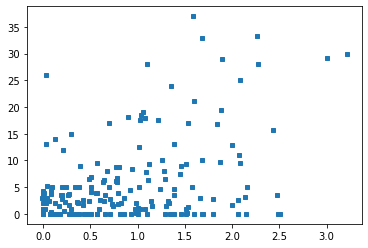

In [142]:
predicted_scores = predict_score_from_threeway(SB_results_w_hits,1,11435)
predicted = [predicted_scores[x] for x in predictions_df["Theraputics"]]
actual = [imm_scores[x] for x in predictions_df["Theraputics"]]

plt.plot(predicted,actual, ls="",marker="s",markersize=4)

correlation, p_val = calculate_correlation_from_predicted_scores(predicted_scores,imm_scores)
print(correlation, p_val)
predictions_df["three_way_humab"] = [predicted_scores[protein] for protein in predictions_df["Theraputics"]]

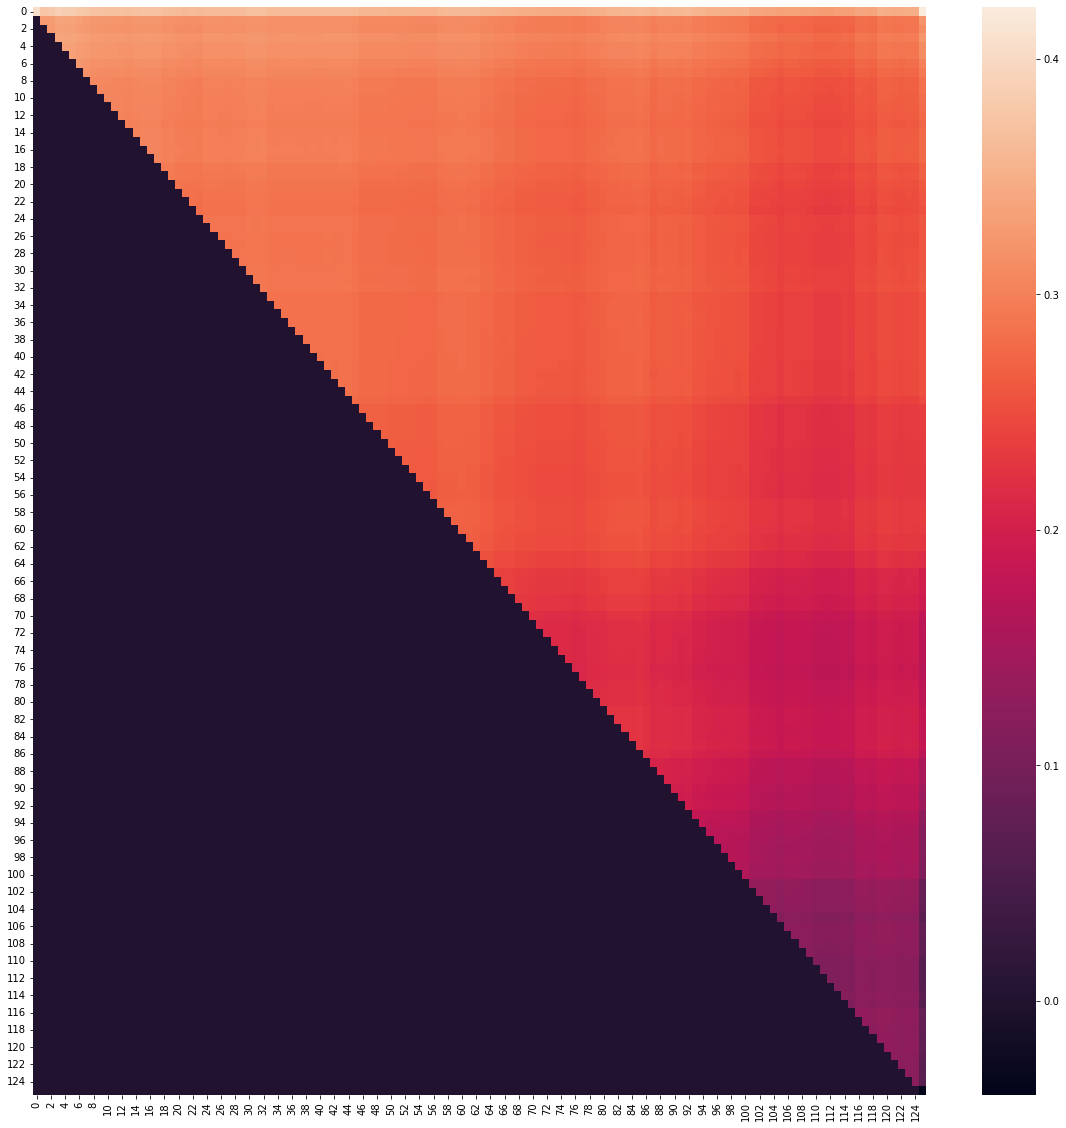

In [143]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(np.array(corr_matrix))
plt.show()

## Asses presentation profiles

Evaluate if immunogenic and non-immunogenic proteins generally have identical presentaion profiles. (Self vs. non-self)
If they generally share a structure the sign of the presentataion scores most likely influence immunogenecity

In [144]:
def generate_presentataion_profile(SB_results_w_hits,lower_threshold=None,Upper_threshold=None):
    ...
# print(SB_results_w_hits)

## Assess presented peptides associated with less immunogenic peptides

Bag-of-word representataion with all presented 9-mers and see how different theraputics locate. If less immunogenic peptides generally locate close to one another.. the actual presented 9-mer cores most likely influences immunogenecity

In [145]:
self_hits = dict()
for theraputic in SB_results_w_hits.keys():
    if imm_scores[theraputic] <= 100:
        self_hits[theraputic] = dict()
        for allele in SB_results_w_hits[theraputic].keys():
            allele_freq = HLA_freqs[allele]
            for peptide in SB_results_w_hits[theraputic][allele]:
                binding_core = peptide[3]
                if binding_core not in self_hits[theraputic].keys():
                    self_hits[theraputic][binding_core] = [allele_freq,peptide[-1]]
                else:
                    self_hits[theraputic][binding_core][0] += allele_freq


In [146]:
unique_presented_cores = [list(x.keys()) for x in self_hits.values()]
unique_presented_cores = sorted(set([item for sublist in unique_presented_cores for item in sublist]),key=lambda x: IMGT_9mers[x] if x in IMGT_9mers.keys() else 0,reverse=True)
bag_of_words = dict()
for theraputic in self_hits.keys():
    bag_of_words[theraputic] = [0]*len(unique_presented_cores)
    for i,core in enumerate(unique_presented_cores):
        if core in list(self_hits[theraputic].keys()):
            bag_of_words[theraputic][i] = 1

In [147]:
len(unique_presented_cores)

1307

In [148]:
labels = list(bag_of_words.keys())
X = np.array([bag_of_words[x] for x in labels])

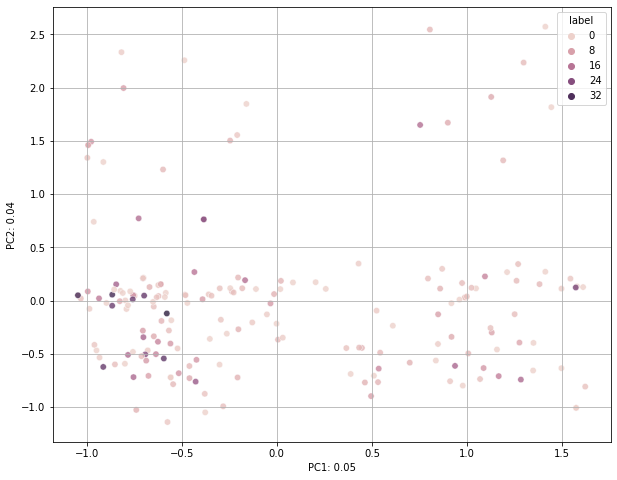

In [149]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
principalDf["label"] = [imm_scores[x]  for x in labels]
fig,axs = plt.subplots(figsize=(10,8))
sns.scatterplot(data=principalDf,x="PC1",y="PC2",hue="label",alpha=0.8,s=40)
axs.set_xlabel(f"PC1: {pca.explained_variance_ratio_[0]:.2f}")
axs.set_ylabel(f"PC2: {pca.explained_variance_ratio_[1]:.2f}")
plt.grid(True)
plt.show()

In [150]:
from sklearn.neighbors import DistanceMetric
import sklearn

# dist = DistanceMetric.get_metric('euclidean')
# dist_mat = dist.pairwise(X)
dist_mat = sklearn.metrics.pairwise.cosine_distances(X)

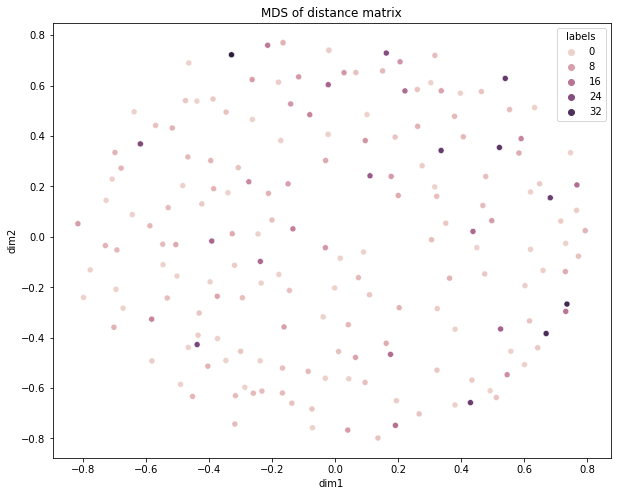

In [151]:

def MDS_analysis(X,labels):
    from sklearn.manifold import MDS
    distance_matrix = X
    mds = MDS(random_state=0,dissimilarity='precomputed',metric=True)
    MDS_transform = mds.fit_transform(distance_matrix)
    
    principalDf = pd.DataFrame(data = MDS_transform
             , columns = ['dim1', 'dim2'])
    principalDf["labels"] = [imm_scores[x] for x in labels]

    fig,axs = plt.subplots(figsize=(10,8))
    sns.scatterplot(data=principalDf, x = principalDf.dim1, y= principalDf.dim2, hue = "labels") # ,style="labels"
    axs.set_xlabel(f"dim1")
    axs.set_ylabel(f"dim2")
    
    #get handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()
    labels_to_handles = {label:handel for handel,label in zip(handles, labels)}

    plt.title("MDS of distance matrix")
    plt.show()

MDS_analysis(dist_mat,labels)

## Heat map analysis of what cores are found in the different mAbs

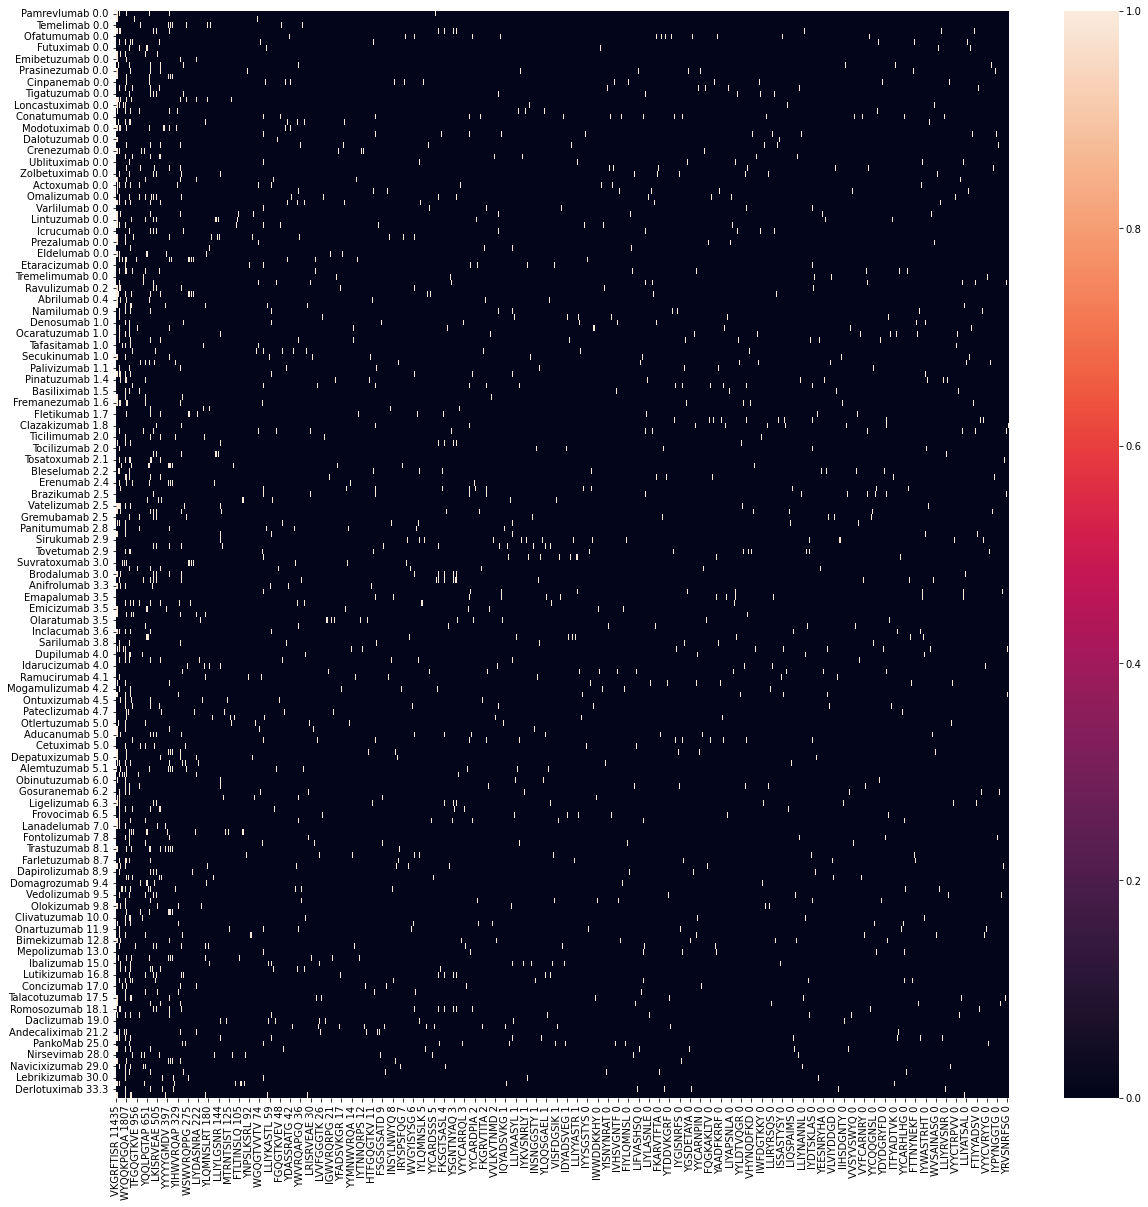

In [152]:
def lookup_imgt(core,IMGT_database):
    if core in IMGT_database.keys():
        return core + " " + str(IMGT_database[core])
    else:
        return core + " " + "0"


indexes = sorted([x + " " + str(round(imm_scores[x],1)) for x in labels],key=lambda x: float(x.split()[-1]))
columns = [lookup_imgt(x,IMGT_9mers) for x in unique_presented_cores]
bag_of_words_df = pd.DataFrame(X,columns=columns,index=indexes)
plt.figure(figsize=(20,20))
sns.heatmap(bag_of_words_df)
plt.show()

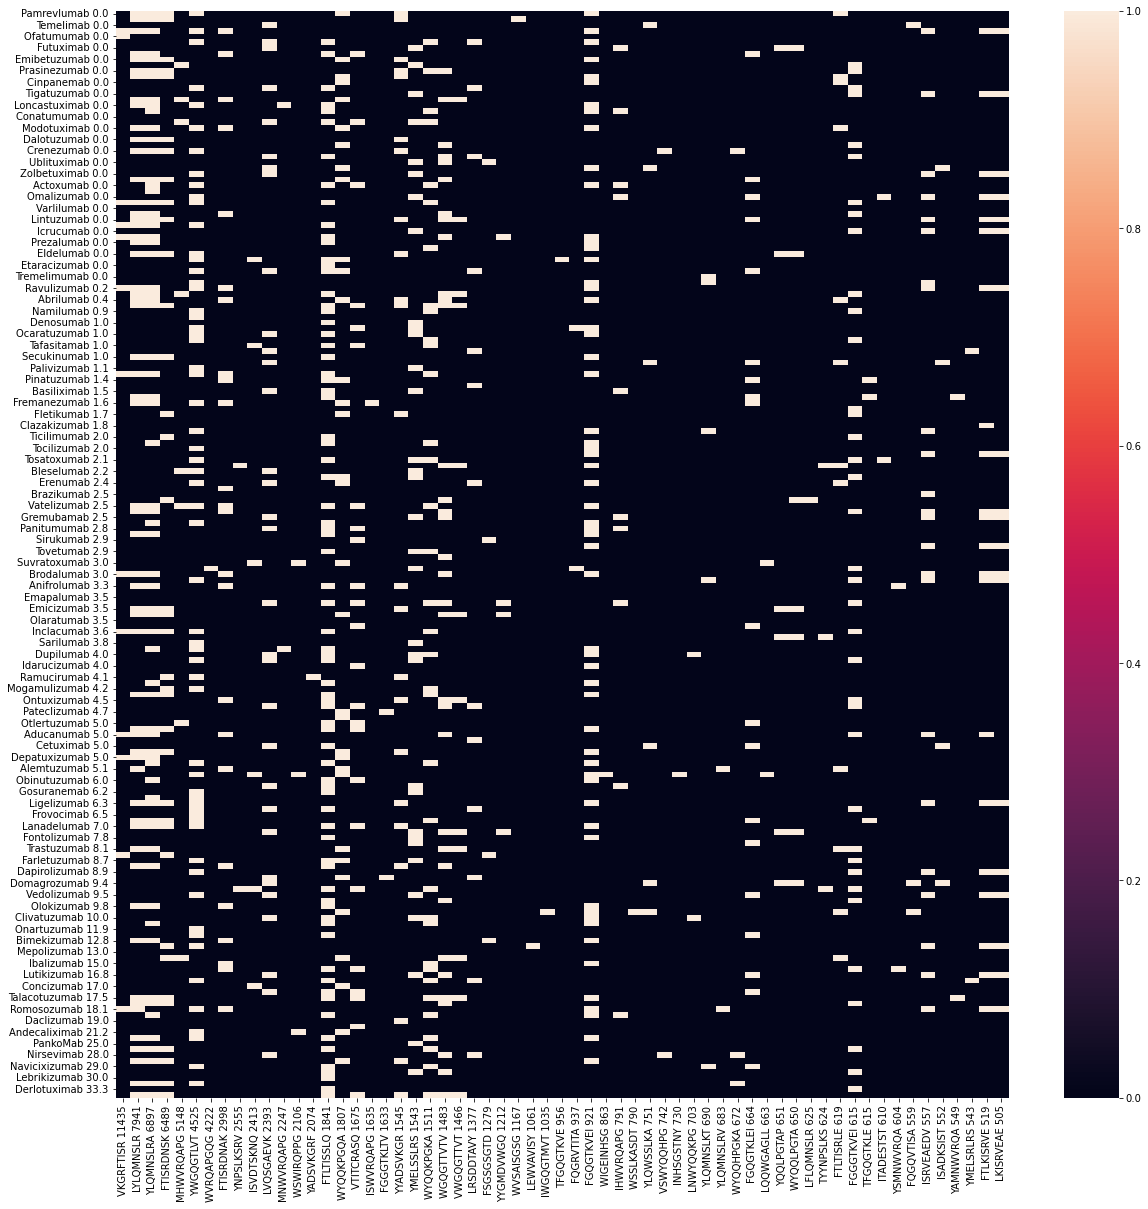

In [153]:
threshold = 500
columns_of_interest = [x for x in bag_of_words_df.columns if x.split()[0] in IMGT_9mers.keys() and IMGT_9mers[x.split()[0]] > threshold]
df_subset = bag_of_words_df.loc[:,columns_of_interest]
plt.figure(figsize=(20,20))
sns.heatmap(df_subset)
plt.show()

In [154]:
presentation_score_associated_w_bag_of_words = dict()
for theraputic in SB_results_w_hits.keys():
    presentation_score_associated_w_bag_of_words[theraputic] = dict()
    for allele in SB_results_w_hits[theraputic].keys():
        for peptide in SB_results_w_hits[theraputic][allele]:
            core = peptide[3]
            allele_freq = HLA_freqs[allele]
            if allele[0:4] == "DRB1":
                score = allele_freq
            else:
                score = 0.2*allele_freq
            
            if core not in presentation_score_associated_w_bag_of_words[theraputic].keys():
                presentation_score_associated_w_bag_of_words[theraputic][core] = score
            else:
                presentation_score_associated_w_bag_of_words[theraputic][core] += score


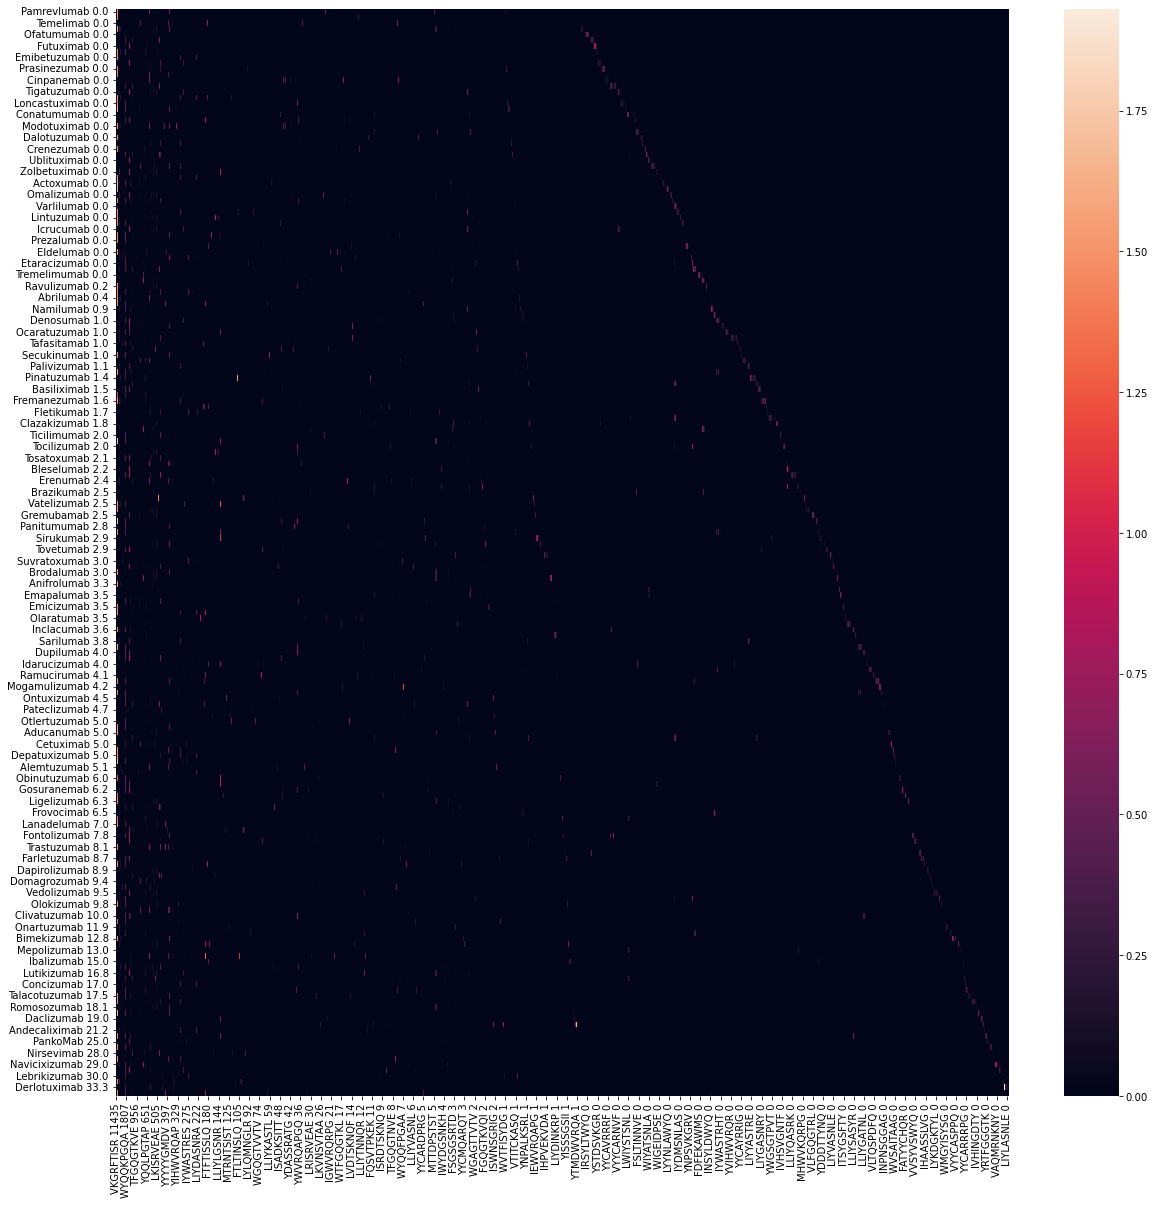

In [155]:
bag_of_words_presentataion_df = pd.DataFrame.from_dict(presentation_score_associated_w_bag_of_words).T
bag_of_words_presentataion_df = bag_of_words_presentataion_df.fillna(0)
indexes = sorted([x + " " + str(round(imm_scores[x],1)) for x in bag_of_words_presentataion_df.index],key=lambda x: float(x.split()[-1]))
columns = [lookup_imgt(x,IMGT_9mers) for x in bag_of_words_presentataion_df.columns]
bag_of_words_presentataion_df.index = indexes
bag_of_words_presentataion_df.columns = columns
sorted_columns = sorted(columns, key=lambda x: int(x.split()[-1]), reverse=True)
bag_of_words_presentataion_df = bag_of_words_presentataion_df.loc[:,sorted_columns]
# bag_of_words_presentataion_df = bag_of_words_presentataion_df.iloc[:,:100]
bag_of_words_presentataion_df = bag_of_words_presentataion_df.iloc[:,:]
plt.figure(figsize=(20,20))
sns.heatmap(bag_of_words_presentataion_df)
plt.show()

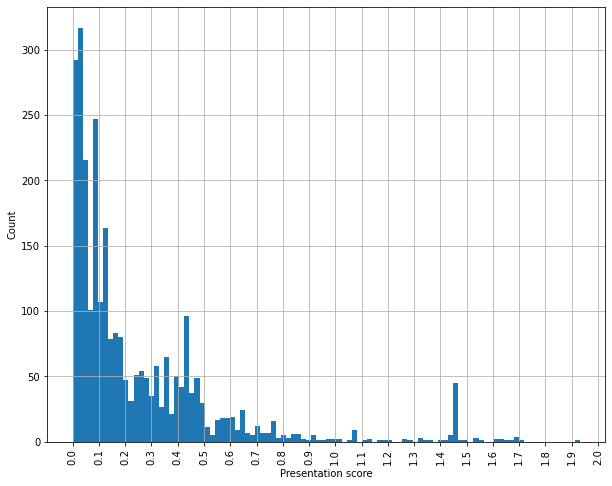

In [167]:
fig = plt.figure(figsize=(10,8))
plt.hist(bag_of_words_presentataion_df.values[bag_of_words_presentataion_df.values > 0],bins=100)
plt.xlabel("Presentation score")
plt.ylabel("Count")
plt.grid(True)
plt.xticks(np.arange(0,2.1,0.1),rotation=90)
plt.show()

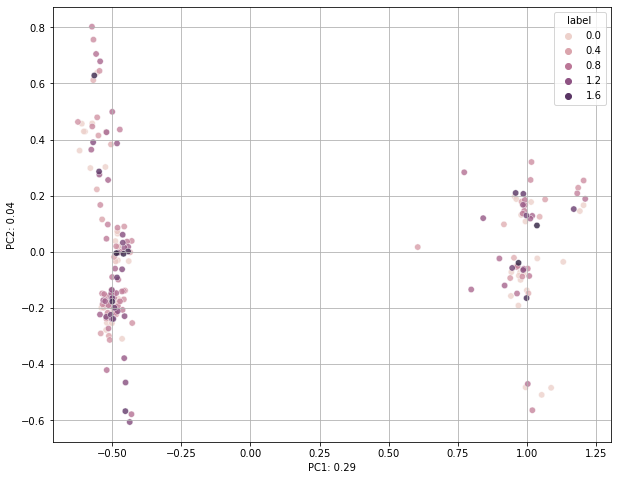

In [121]:
labels = [x.split()[0] for x in bag_of_words_presentataion_df.index]
X = bag_of_words_presentataion_df.values
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalComponents = principalComponents + np.random.normal(0,0.02,principalComponents.shape)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
principalDf["label"] = [np.log10(imm_scores[x] + 1) for x in labels]

fig,axs = plt.subplots(figsize=(10,8))
sns.scatterplot(data=principalDf,x="PC1",y="PC2",hue="label",alpha=0.8,s=40)
axs.set_xlabel(f"PC1: {pca.explained_variance_ratio_[0]:.2f}")
axs.set_ylabel(f"PC2: {pca.explained_variance_ratio_[1]:.2f}")
plt.grid(True)
plt.show()

## Regression tree predictions

100%|██████████| 4/4 [00:00<00:00, 49.17it/s]

0.14226942952496305
Best lambda 0.4


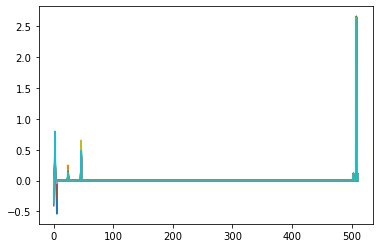

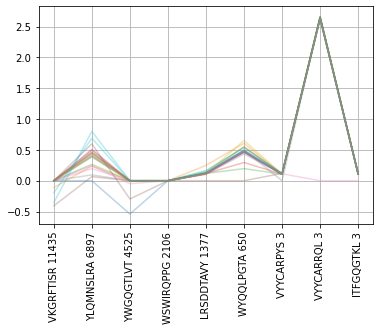

Index(['VKGRFTISR 11435', 'YLQMNSLRA 6897', 'YWGQGTLVT 4525', 'WSWIRQPPG 2106',
       'LRSDDTAVY 1377', 'WYQQLPGTA 650', 'VYYCARPYS 3', 'VYYCARRQL 3',
       'ITFGQGTKL 3'],
      dtype='object')


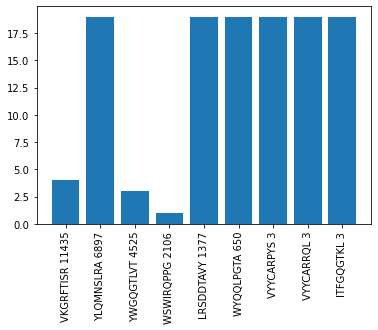

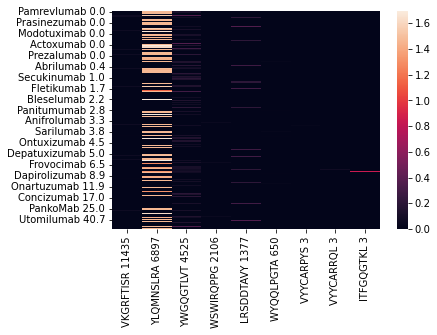

SpearmanrResult(correlation=-0.215929776159183, pvalue=0.00219061764116257)


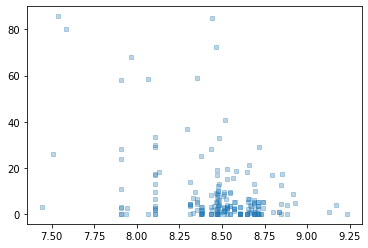

In [123]:
from sklearn.model_selection import LeaveOneOut,LeavePOut,KFold
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,Ridge, ElasticNet



def plot_lasso_regression(all_weights,df):
    indexes_of_interest = []
    for weights in all_weights:
        non_zero_selection = [i for i in range(len(weights)) if weights[i] != 0]
        plt.plot(weights)
        indexes_of_interest += non_zero_selection
    
    plt.show()
    unique, counts = np.unique(indexes_of_interest,return_counts=True)
    for weights in all_weights:
        plt.plot(weights[unique],alpha=0.3)
    plt.xticks(np.arange(len(unique)),list(df.columns[unique]),rotation=90)
    plt.grid(True)
    plt.show()
    print(df.columns[unique])
    plt.bar(np.arange(len(counts)),counts)
    plt.xticks(np.arange(len(unique)),list(df.columns[unique]),rotation=90)
    plt.show()

    sns.heatmap(df.loc[:,df.columns[unique]])
    plt.show()


threshold = 0.2 # Threshold of 0.2 is intersting with
columns_of_interest = [x for x in bag_of_words_presentataion_df.columns if (bag_of_words_presentataion_df.loc[:,x] >= threshold).any()]
filtered_presentataion = bag_of_words_presentataion_df.loc[:,columns_of_interest]


test = filtered_presentataion.sample(frac=1, random_state=1)
X = test.values
proteins = test.index.to_numpy()
y = np.array([imm_scores[x.split()[0]] for x in proteins])


loo = KFold(n_splits=20)
regressor_predictions = []
y_actual = []

performances = []
lambda_range = np.arange(0.1,0.5,0.1)
for lambda_ in tqdm(lambda_range,total=len(lambda_range)):
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regressor = ElasticNet(alpha=lambda_)
        regressor.fit(X_train,y_train)
        predictions = regressor.predict(X_test)
        regressor_predictions += predictions.tolist()
        y_actual += y_test.tolist()
    performance = abs(scipy.stats.spearmanr(regressor_predictions,y_actual)[0])
    performances.append(performance)


best_lambda = lambda_range[np.argmax(performances)]
print(performances[np.argmax(performances)])
print("Best lambda",best_lambda)
loo = KFold(n_splits=20)
regressor_predictions = []
y_actual = []
all_weights = []
for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = ElasticNet(alpha=0.4)
    regressor.fit(X_train,y_train)
    all_weights.append(regressor.coef_)
    predictions = regressor.predict(X_test)
    regressor_predictions += predictions.tolist()
    y_actual += y_test.tolist()
    performance = abs(scipy.stats.spearmanr(regressor_predictions,y_actual)[0])

plot_lasso_regression(all_weights,bag_of_words_presentataion_df)
print(scipy.stats.spearmanr(regressor_predictions,y_actual))
plt.plot(regressor_predictions,y, ls="", marker="s",markersize=4,alpha=0.3)
plt.show()
regressor_prediction_dict = {x.split()[0]:y for x,y in zip(proteins,y_actual)}
predictions_df["tree_predictions"] = [regressor_prediction_dict[protein] for protein in predictions_df["Theraputics"]]

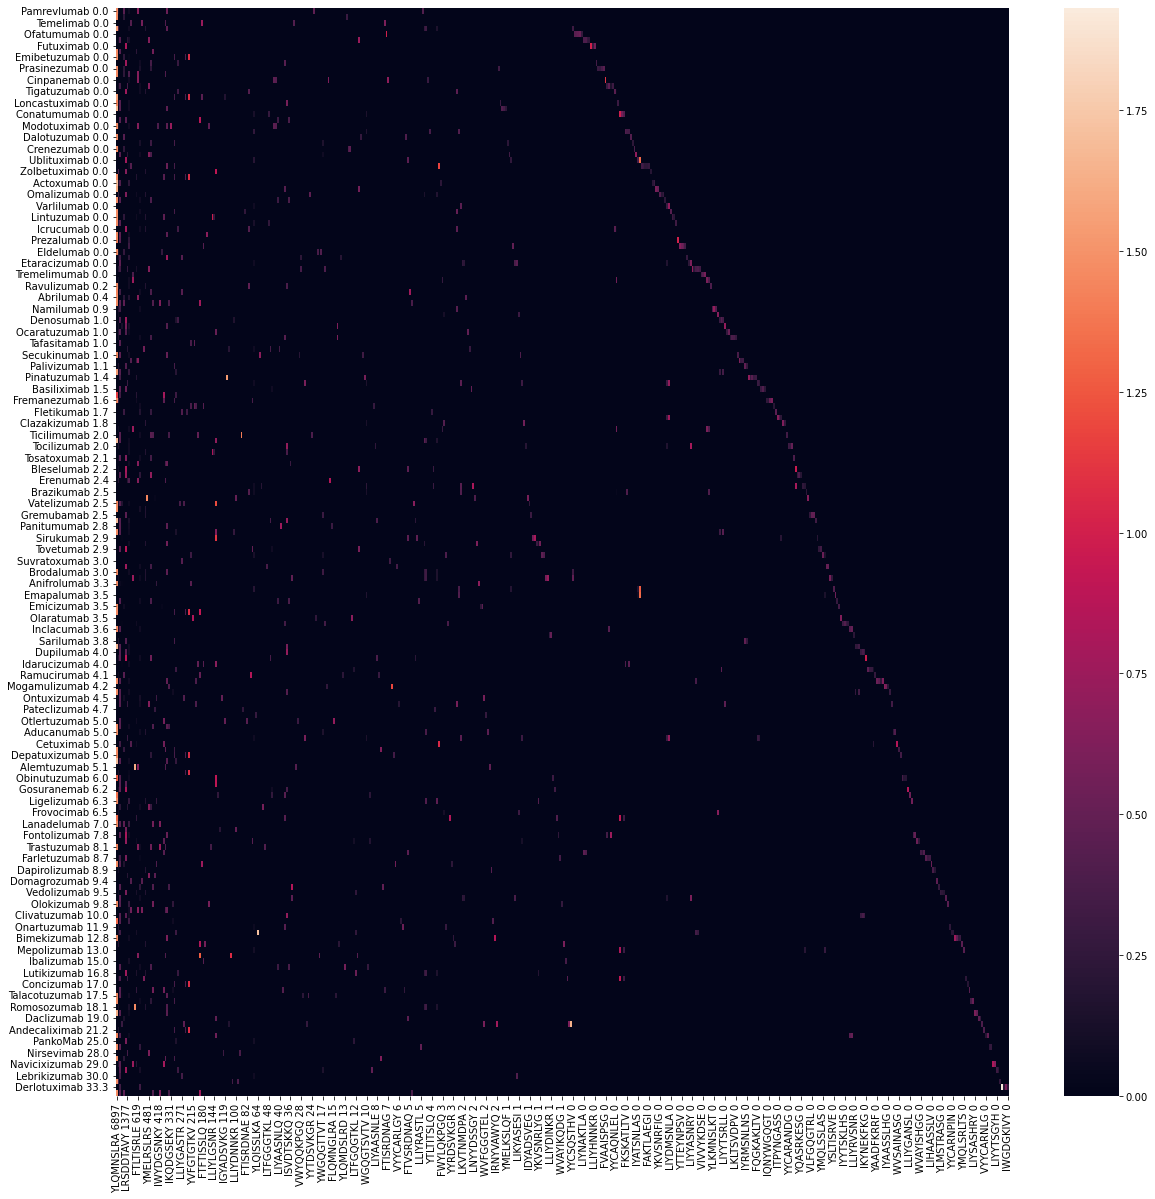

In [81]:
plt.figure(figsize=(20,20))
sns.heatmap(filtered_presentataion)
plt.show()

## Linear Discriminant Analysis

In [82]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Create label
def create_labels(scores):
    bins = [x for x in np.arange(0,100,5)]
    labels = []
    for imm_score in scores:
        diff = [abs(bin-imm_score) for bin in bins]
        correct_bin = bins[np.argmin(diff)]
        labels.append(correct_bin)
    return labels

scores = [float(x.split()[-1]) for x in bag_of_words_presentataion_df.index]
y_transform = create_labels(scores)
X = bag_of_words_presentataion_df.to_numpy()


clf = LinearDiscriminantAnalysis()
clf.fit(X, y_transform)



LinearDiscriminantAnalysis()

## Binning strategies - for performance

Is there to much noise in ranking making SCC worse than it actually is? 

If i force an uniform distrobution on the data is it easier to classify? 

In [579]:
import random
random.seed(0)
bins = [x for x in np.arange(0,100,2)]

def get_binned_data(bins,imm_scores):
    # Bin the data
    binned_data = {x:[] for x in bins}
    for theraputic in imm_scores.keys():
        diff = [abs(bin-imm_scores[theraputic]) for bin in bins]
        correct_bin = bins[np.argmin(diff)]
        binned_data[correct_bin].append(theraputic)
    
    # Remove empty bins
    final_dict = {bin: binned_data[bin] for bin in binned_data.keys() if (len(binned_data[bin]) > 0)} #  and bin < 40

    return final_dict

def boot_strap_binned_data(binned_data,samples):
    boot_strapped_data = []
    for i in range(samples):
        sample = []
        for bin in binned_data.keys():
            pick = random.choice(binned_data[bin])
            sample.append(pick)
        boot_strapped_data.append(sample)
    return boot_strapped_data

def asses_predictive_performance_in_bins(boot_strap_binned_data,prediction_df,prediction_name):
    SCCs = []
    for dataset in boot_strap_binned_data:
        sub_sample = prediction_df[prediction_df["Theraputics"].isin(dataset)]
        coeff, p_value = scipy.stats.spearmanr(sub_sample[prediction_name],sub_sample["immunogenecity_scores"])
        SCCs.append(coeff)
    return np.mean(SCCs)
    
binned_data = get_binned_data(bins,imm_scores)
boot_strapped_data = boot_strap_binned_data(binned_data,10000)
print("Onestate SCC:",asses_predictive_performance_in_bins(boot_strapped_data,predictions_df,"Onestate"))
print("Twostate SCC:",asses_predictive_performance_in_bins(boot_strapped_data,predictions_df,"Twostate"))
print("Threeway SCC:",asses_predictive_performance_in_bins(boot_strapped_data,predictions_df,"Threeway"))
print("Threeway humab-optimized SCC:",asses_predictive_performance_in_bins(boot_strapped_data,predictions_df,"three_way_humab"))
print("Tree-predictions SCC:",asses_predictive_performance_in_bins(boot_strapped_data,predictions_df,"tree_predictions"))

print("WUHUU!")

Onestate SCC: -0.15190184517134278
Twostate SCC: 0.5239432270721607
Threeway SCC: 0.5817014821133376
Threeway humab-optimized SCC: 0.5817014821133376
Tree-predictions SCC: 1.0
WUHUU!


## Find best threshold for upper using the binned dataset

In [578]:
def predict_score_from_threeway(SB_results,lower_threshold,upper_threshold):
    predicted_scores = dict()
    for theraputic in SB_results.keys():
        predicted_scores[theraputic] = 0
        for allele in SB_results[theraputic].keys():
            allele_freq = HLA_freqs[allele]
            for peptide in SB_results[theraputic][allele]:
                self_similarity_score = peptide[-1]
                if self_similarity_score >= upper_threshold:
                    if allele[0:4] == "DRB1":
                        predicted_scores[theraputic] -= allele_freq
                    else:
                        predicted_scores[theraputic] -= 0.2*allele_freq
                elif self_similarity_score < upper_threshold: 
                    if allele[0:4] == "DRB1":
                        predicted_scores[theraputic] += allele_freq
                    else:
                        predicted_scores[theraputic] += 0.2*allele_freq

    return predicted_scores

def calculate_correlation_from_predicted_scores(predicted_scores_dict,imm_scores):
    predicted_scores = []
    actual_scores = []
    for theraputic in SB_results.keys():
        actual_scores.append(imm_scores[theraputic])
        predicted_scores.append(predicted_scores_dict[theraputic])
        
    return scipy.stats.pearsonr(predicted_scores,actual_scores)

def get_correlation_of_binned_data(boot_strapped_data,imm_scores,predicted_scores):
    SCCs = []
    for dataset in boot_strapped_data:
        predictions = [predicted_scores[x] for x in dataset]
        actual_scores = [imm_scores[x] for x in dataset]

        coeff, p_value = scipy.stats.spearmanr(predictions,actual_scores)
        SCCs.append(coeff)
    return np.mean(SCCs)

sorted_range = sorted(unique_self_scores)[::10]

all_sccs = []
for i in tqdm(range(len(sorted_range)),total=len(sorted_range)):
    lower_threshold = 1
    upper_threshold = sorted_range[i]
    predicted_scores = predict_score_from_threeway(SB_results_w_hits,lower_threshold,upper_threshold)
    mean_scc = get_correlation_of_binned_data(boot_strapped_data,imm_scores,predicted_scores)
    all_sccs.append(mean_scc)
        
plt.plot(all_sccs)
plt.show()

  8%|▊         | 2/26 [00:04<00:49,  2.05s/it]


KeyboardInterrupt: 

# Training trees with binned data

In [254]:
import copy
def encode_w_df(prediction_df, protein):
    prediction_df = copy.deepcopy(prediction_df)
    prediction_df.index = [x.split()[0] for x in prediction_df.index]
    return prediction_df.loc[protein,:].to_list()

def train_regressor(prediction_df,proteins,imm_sub_sample):
    X = np.array([encode_w_df(prediction_df,protein) for protein in proteins])
    y = np.array([imm_sub_sample[x] for x in proteins])
    regressor = DecisionTreeRegressor()
    regressor.fit(X,y)
    return regressor

data = predictions_df.loc[:,["Theraputics","immunogenecity_scores"]]
X = data["Theraputics"].to_numpy()
y = data["immunogenecity_scores"].to_numpy()

bins = [x for x in np.arange(0,100,1)]
all_precitions = []
all_true = []
for i, (train_index, test_index) in tqdm(enumerate(loo.split(X)),total=loo.get_n_splits(data)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    imm_sub_sample = {x:imm_scores[x] for x in X_train if x not in X_test}
    binned_data = get_binned_data(bins,imm_sub_sample)
    boot_strapped_data = boot_strap_binned_data(binned_data,1000)

    all_regressors = []
    for sample in boot_strapped_data:
        regressor = train_regressor(bag_of_words_presentataion_df,sample,imm_sub_sample)
        all_regressors.append(regressor)
    
    X_test_encoded = np.array(encode_w_df(bag_of_words_presentataion_df,X_test[0])).reshape(1,-1)
    prediction = np.mean([model.predict(X_test_encoded) for model in all_regressors])
    all_precitions.append(prediction)
    all_true.append(y_test[0])


100%|██████████| 199/199 [24:16<00:00,  7.32s/it]


Tree-predictions boot-strapped SCC: 0.1953307254623044


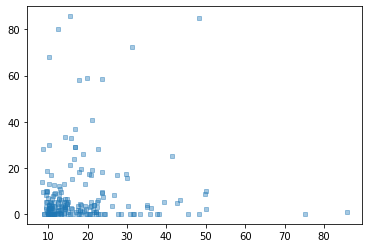

In [265]:
predictions_df["tree_bootstrapped_training"] = all_precitions
print("Tree-predictions boot-strapped SCC:",asses_predictive_performance_in_bins(boot_strapped_data,predictions_df,"tree_bootstrapped_training"))
plt.plot(all_precitions,all_true,ls="",marker="s",markersize=4,alpha=0.4)
plt.show()

# Asses distrobutions of self-hits

Does it makes sense that peptides found >1 time would be considered less immunogenic?

In [145]:
distrobutions = dict()
for theraputic in SB_results_w_hits.keys():
    distrobutions[theraputic] = []
    for allele in SB_results_w_hits[theraputic].keys():
        allele_freq = HLA_freqs[allele]
        for peptide in SB_results_w_hits[theraputic][allele]:
            binding_core = peptide[3]
            distrobutions[theraputic].append(peptide[-1])


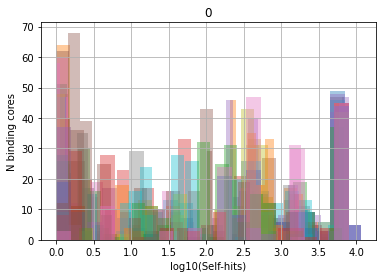

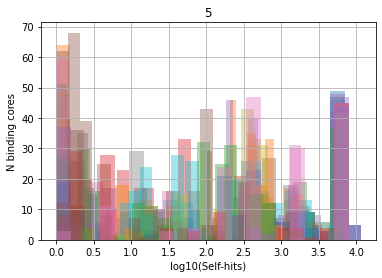

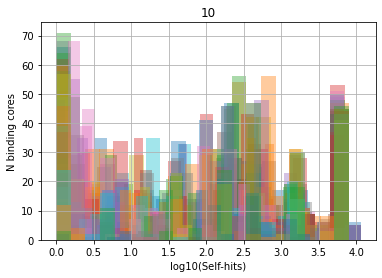

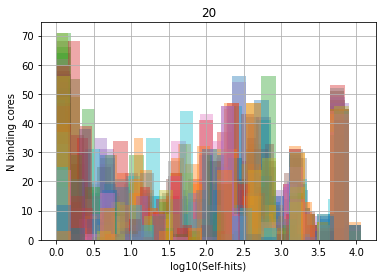

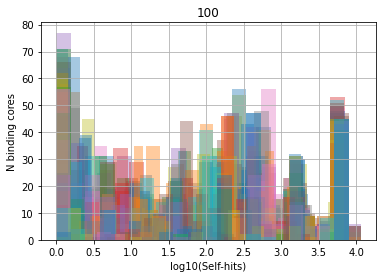

In [146]:
thresholds = [0,5,10,20,100]
for i,threshold in enumerate(thresholds):
    for theraputic in distrobutions.keys():
        if i != 0:
            if imm_scores[theraputic] <= threshold and thresholds[i-1] >= imm_scores[theraputic]:
                plt.hist(np.log10(np.array(distrobutions[theraputic]) + 1),bins=20,alpha=0.4)
        else:
            if imm_scores[theraputic] <= threshold:
                plt.hist(np.log10(np.array(distrobutions[theraputic]) + 1),bins=20,alpha=0.4)

    plt.title(threshold)
    plt.xlabel("log10(Self-hits)")
    plt.ylabel("N binding cores")
    plt.grid(True)
    plt.show()

In [253]:
predictions_df

,Theraputics,Threeway,Twostate,Onestate,immunogenecity_scores,tree_predictions
0,Ipilimumab,-4.45600,0.00000,4.45600,2.000000,1.663650
1,Emapalumab,-2.12530,0.00000,2.12530,3.500000,0.816640
2,Anifrolumab,-3.49784,0.00000,3.49784,3.333333,12.594971
3,Solanezumab,-3.06210,0.71850,4.49910,3.500000,6.565947
4,Itolizumab,1.27772,2.49214,3.70656,15.750000,7.896895
...,...,...,...,...,...,...
194,Galcanezumab,-1.59630,0.80038,3.19706,8.700000,1.458601
195,Mepolizumab,-1.57516,0.03330,1.64176,13.000000,4.204384
196,Avelumab,-2.75674,0.37808,3.51290,5.000000,4.922676
197,Lebrikizumab,2.25472,3.20914,4.16356,30.000000,2.247305
